##### MODULE 6 | LESSON 3

# **Geographically Weighted Regression (GWR)**


|  |  |
|:---|:---|
|**Reading Time** | 2h  |
|**Prior Knowledge** | basic statistics, linear regression, Python |
|**Keywords** | Spatial analysis, regression, GWR, spatial heterogeneity, kernel |

---

*In this lesson, we will be introducing geographically weighted regression as an easy and intuitive way of modeling data that exhibit spatial heterogeneity. We explore the theoretical foundations of GWR, starting with its motivation and how it extends traditional linear regression to account for spatial heterogeneity. In the second half of the notebook, we follow a more hands-on approach with illustrations and a real-world data example in order to complement the theory with the necessary skills one would need in order to use GWR in practice.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# **1. Geographically Weighted Regression**

Geographically weighted regression is an extension of the traditional linear regression that accounts for **spatial heterogeneity** in relationships between variables. This type of regression allows coefficients to vary geographically, capturing the differences in relationship between different points in space. In short, it is a regression that takes into account the location of the dependent variable on the map and assumes that its relation with the independent variables can very well be different from those of a different point on the map.

In order to achieve the above results, the GWR framework performs as many linear regressions as the number of data points on a map. Each of those regressions is a weighted linear regression (WLS) where the weights play the role of a decaying factor: the further one point is from where the WLS takes place, the less important that point becomes.

The first thing that becomes clear is that the coefficients of the GWR will not be constant across the map. On the contrary, for each point, we will end up with a unique set of coefficients, along with an intercept and an error term. But this is exactly the strength of this framework: that it allows for a thorough understanding of how relationships between variables change across space.

Let's start by formulating a traditional linear regression. In the context of GWR, we can refer to the traditional linear regression as *"global"* since the latter approach assumes global (constant) coefficients. The LR formula is:

**Traditional Linear Regression**

$$
y_{i} = \beta_{0} + \sum_{k = 1}^{p} \beta_{i} \cdot x_{ik} + \epsilon_{i}
$$

where

* $y$ is the dependent variable
* $\beta_{i}$ are the coefficients (assumed constant across all observations)
* $x_{ik}$ are the $k$ independent variables and
* $\epsilon_{i}$ are the errors


**Geographically Weighted Regression**

In GWR, we allow the coefficients to vary by location; thus, they become a function of space: $\beta(u, v)$, where $(u,v)$ are the coordinates.

$$
y_{i} = \beta_{0}(u_{i}, v_{i}) + \sum_{k=1}^{p}\beta_{k}(u_{i}, v_{i})x_{ik} + \epsilon{i}
$$

The above notation hides an important inconvenience: for each point on the map, we only have a single (or maybe a few) observations. This means that it is not possible to reliably estimate the coefficients at each point using the OLS estimator. In order to account for this, we make use of a spatial weighting scheme that encodes the influence of the points to the point of interest. Naturally, the faraway points are assigned a smaller weight than the ones closer. The end result is a diagonal weight matrix $W$ that contains values that range from 0 to 1.

What we actually changed by using a weight matrix here is that for each point on the map, we will estimate $\beta{i}$ using all the available observations weighted in terms of proximity to the point of interest. The estimation of the coefficients can now be given by:

$$
\hat \beta(u_{i}, v_{i}) = [X^{T} W(u_{i}, v_{i}) X]^{-1} X^{T} W(u_{i}, v_{i}) y
$$

It follows that the predicted value of each observation is given by:

$$
\hat y_{i} = X_{i} [X^{T} W(u_{i}, v_{i}) X]^{-1} X^{T} W(u_{i}, v_{i}) y
$$

If we set:

$$
S_{i} = X_{i} [X^{T} W(u_{i}, v_{i}) X]^{-1} X^{T} W(u_{i}, v_{i}) \text{ and } C_{i} = [X^{T} W(u_{i}, v_{i}) X]^{-1} X^{T} W(u_{i}, v_{i})
$$

the local covariance matrix $V_{i}$ of the parameter estimates becomes:

$$
V_{i} = C_{i} C^{T}_{i} \hat \sigma^{2}
$$

where $\hat \sigma^{2}$ is the estimated standard deviation of the error term, which is defined as:

$$
\hat \sigma^{2} = \frac{\sum (y_{i} - \hat y_{i})^{2}}{m - tr(S)}
$$

Let's now check the weighting scheme.

### **1.1 Weighting Scheme (Data-Borrowing Scheme)**

The weighting scheme in GWR is also called a "data-borrowing scheme." This terminology emphasizes an important aspect of GWR: that spatial proximity-borrowing nearby observations-is essential in estimating local regression coefficients.

The weights assigned to each observation are given by spatial kernel functions. The three most common kernels include the:

* **Gaussian Kernel**:

$$
w_{ij} = \exp \left ( -\frac{d^{2}_{ij}}{2b^{2}} \right )
$$

* **Bisquare Kernel**:

$$
w_{ij} = \begin{cases}
     \left ( 1 - \left ( \frac{d_{ij}}{b} \right )^{2} \right )^2 & \text{ if } d_{ij} < b \\
     0 & \text{ otherwise }
\end{cases}
$$

* **Exponential Kernel**:

$$
w_{ij} = \exp \left ( -\frac{d_{ij}}{b} \right )
$$

where

* $w_{ij}$ are the weight for observation $j$ when estimating the model at observation $i$

* $d_{ij}$ is the distance between $i$ and $j$

* $b$ is the bandwidth parameter controlling the decay of weights with distance

**Distance**

The choice of the distance metric between two points is case specific. In many occasions, the Euclidean distance, which measures the straight line between two points, will suffice:

$$
d_{ij} = \sqrt{(u_{i} - u_{j})^{2} + (v_{i} - v_{j})^{2}}
$$

But if the problem requires that grid-like street patterns are taken into account, then one can use the Manhattan distance:

$$
d_{ij} = |u_{i} - u_{j}| + |v_{i} - v_{j}|
$$

If we further assume that the area of interest is large (the curvature of Earth becomes a factor) and/or the landscape includes varied terrains, then geodesic lines or geodesic distance could be more appropriate.

**Bandwidth Parameter**

The Bandwidth $b$ controls the trade-off between bias and variance by controlling the proximity of the points that will be used in the local regressions. A small bandwidth will emphasize local variations, keeping a small number of observations to estimate the parameters. A large bandwidth can reduce the coefficient variance but might as well miss local characteristics due to the "oversmooth" that will be applied by incorporating far-away points in the analysis. The bandwidth is normally selected with cross validation (CV) or Akaike information criterion (AIC).

Let's illustrate what the kernels look like in practice. In the next example, we will use a square "map," which consists of $100 \times 100 = 10,000$ observations. The illustrations include all three kernels and show the differences between using Manhattan and Euclidean distance. For simplicity, the point of interest will be fixed and placed at the center of the map.

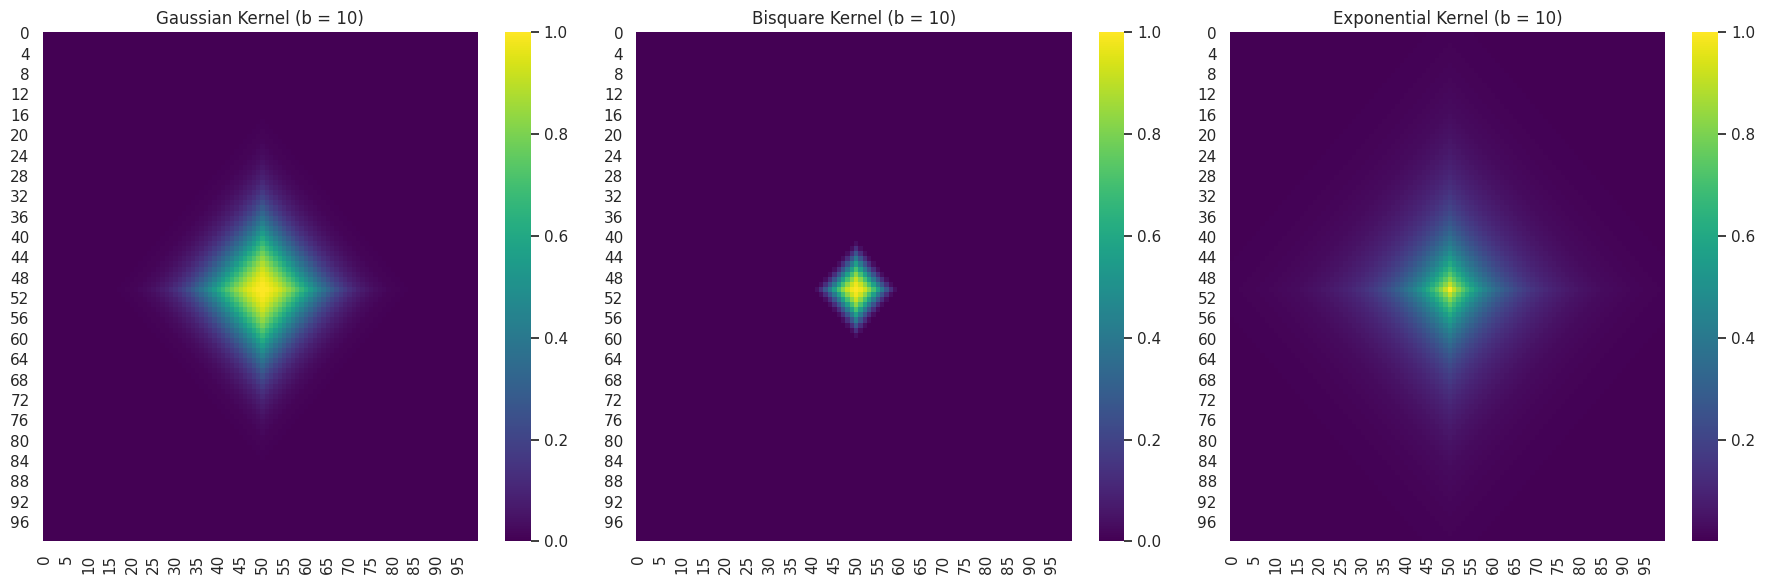

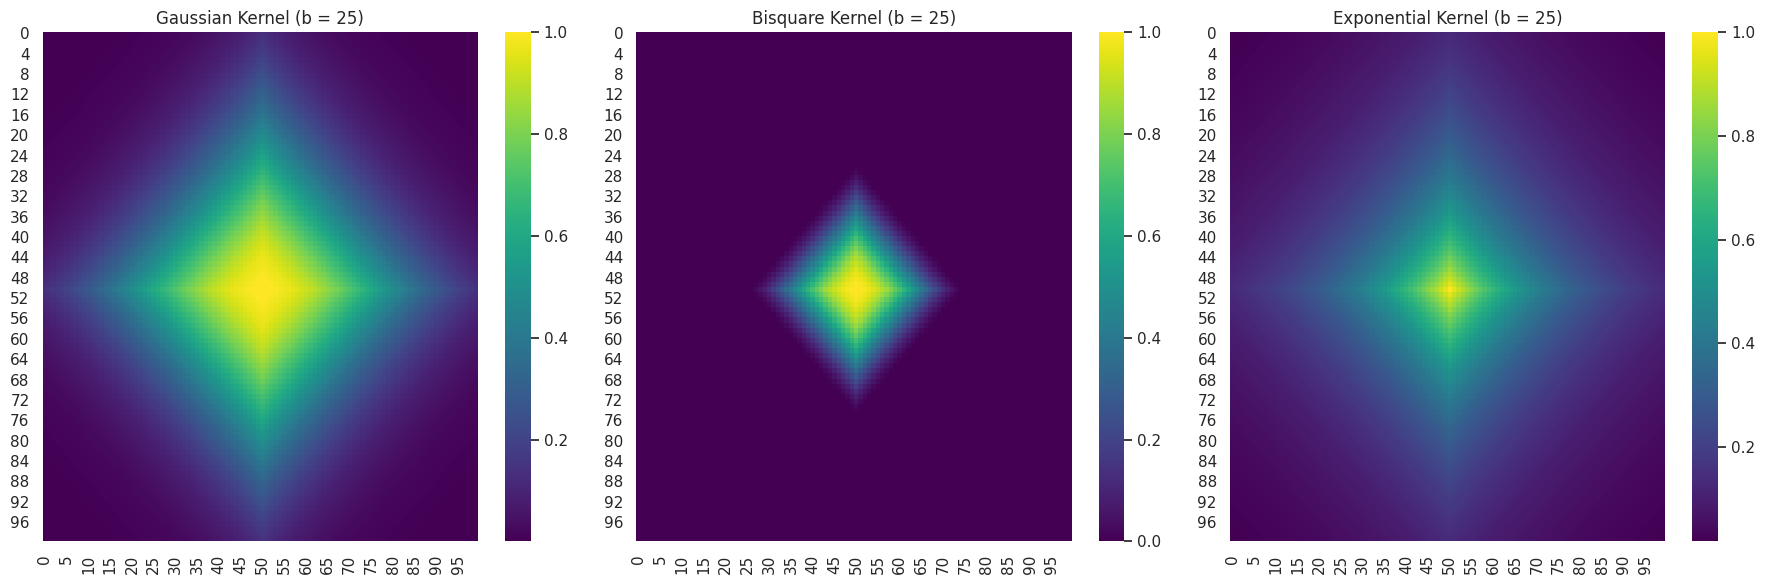

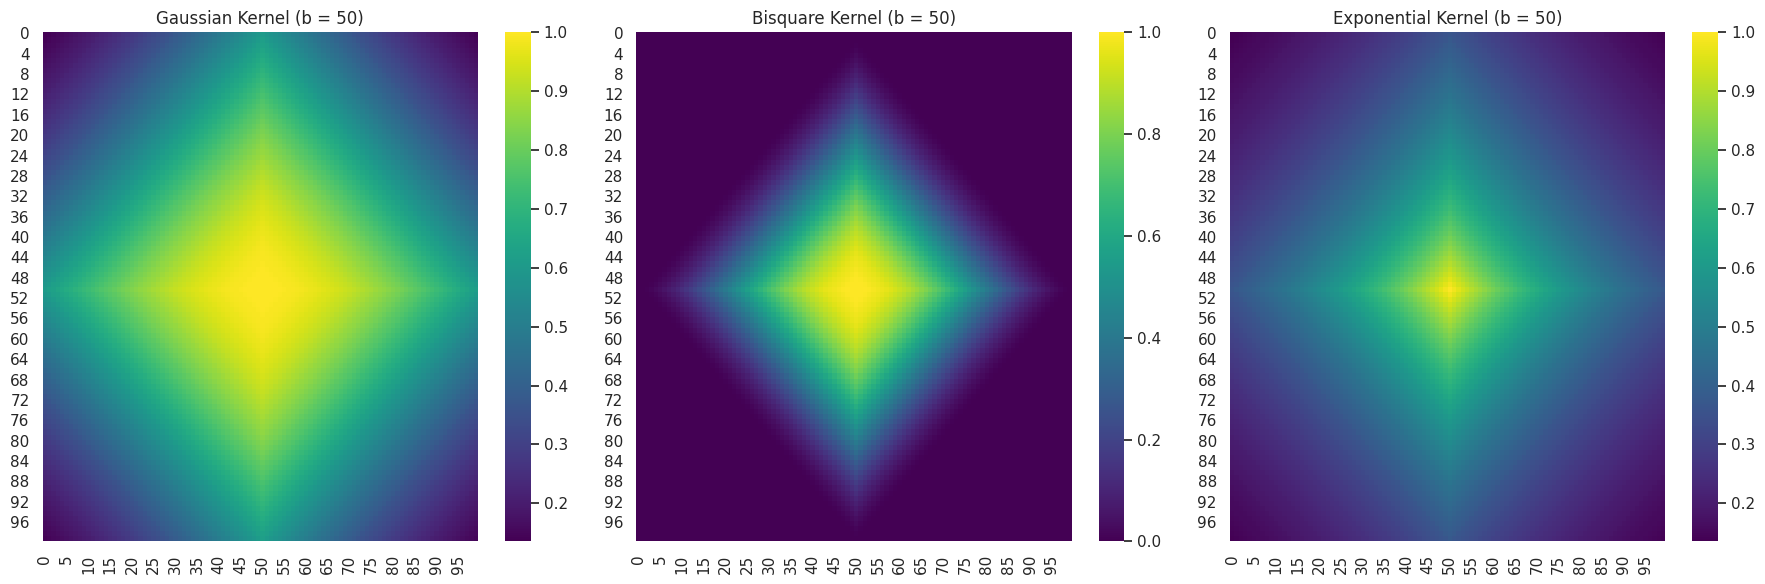

In [2]:
# Figure 1
# Create a meshgrid
i_indices = np.arange(100)
j_indices = np.arange(100)
I, J = np.meshgrid(i_indices, j_indices, indexing='ij')

# Manhattan and Euclidean distances
manhattan_distance = np.abs(I - 50) + np.abs(J - 50)
euclidean_distance = np.sqrt((I - 50)**2 + (J - 50)**2)

# Kernel functions
def gaussian_kernel(D, b):
    return np.exp(- (D ** 2) / (2 * b ** 2))

def bisquare_kernel(D, b):
    return ((1 - (D / b) ** 2) ** 2) * (D < b) # Comment this line yourself

def exponential_kernel(D, b):
    return np.exp(- D / b)

# Plotting function
def plot_kernels(D, bandwidth):
    # Compute weights
    W_gaussian = gaussian_kernel(D, bandwidth)
    W_bisquare = bisquare_kernel(D, bandwidth)
    W_exponential = exponential_kernel(D, bandwidth)

    # Set up the plot
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Gaussian Kernel
    sns.heatmap(W_gaussian, cmap='viridis', ax=axs[0])
    axs[0].set_title(f'Gaussian Kernel (b = {bandwidth})')

    # Bisquare Kernel
    sns.heatmap(W_bisquare, cmap='viridis', ax=axs[1])
    axs[1].set_title(f'Bisquare Kernel (b = {bandwidth})')

    # Exponential Kernel
    sns.heatmap(W_exponential, cmap='viridis', ax=axs[2])
    axs[2].set_title(f'Exponential Kernel (b = {bandwidth})')

    plt.tight_layout()
    plt.show()


# Plot the kernels using manhattan distance
for b in [10, 25, 50]:
    plot_kernels(D = manhattan_distance, bandwidth=b)

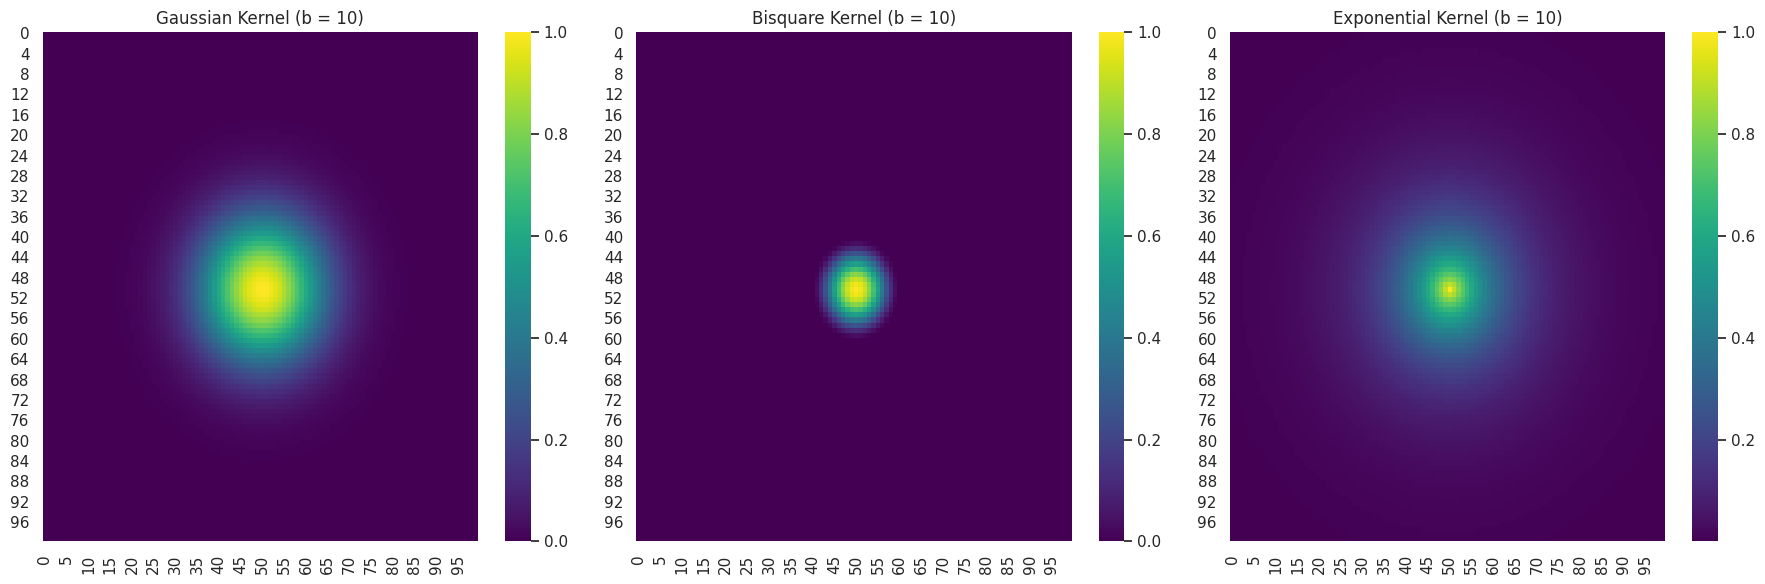

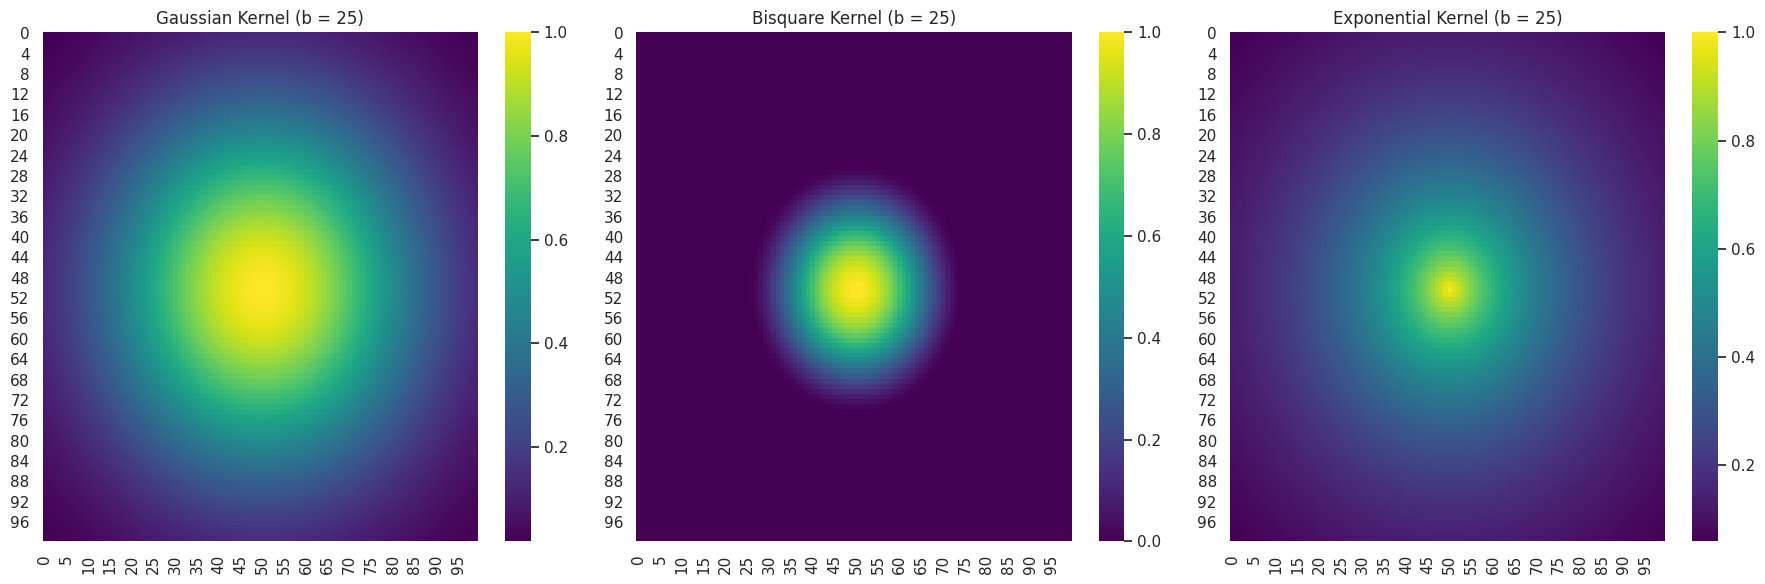

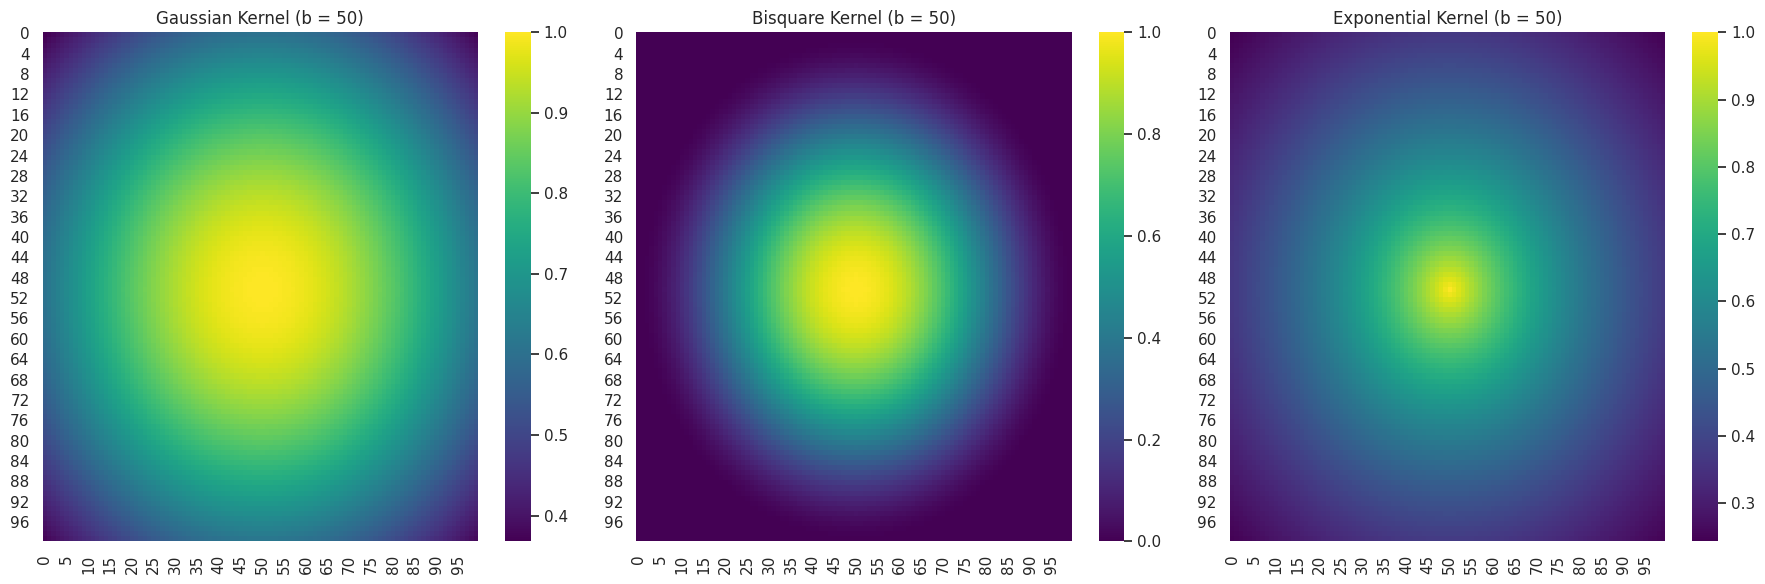

In [3]:
# Figure 2
# Plot the kernels using Euclidean distance
for b in [10, 25, 50]:
    plot_kernels(D = euclidean_distance, bandwidth=b)

In Figures 1 and 2, we observe the effect of the bandwidth in proximity selection. As the bandwidth increases, the area that is used in the local regression increases as well. We can also see that the shape of the area in each distance metric is different. More importantly, the illustrations make clear the differences between the kernels:

* Gaussian: gradual and smooth decay starting from the point of interest

* Bisquare: sharp cut-off that defines the clear borders of influence

* Exponential: rapid decay but with large tails that account for long-distance effects



# **2. Application of Geographically Weighted Regression (GWR)**
In this section, we are going to apply what we learned about GWR from the last section to real-world data.
<br>
## **2.1 Importing the Data Source**
We will use Airbnb rental data from the Prenzlauer Berg (Prenz) neighborhood in Berlin, Germany, as our example data (Oshan et al.). Prenz is a popular destination for tourists. It provides a lot of dining, art, and night life options for visitors. We will use the data to understand what the key drivers are for the Airbnb rental prices in this neighborhood. This dataset is available through a Python package libpysal. Hence, we will need to to install this package first. The other python package we need to install is mgwr. This is the Python package to run GWR. Now let's install these two packages.

In [4]:
pip install libpysal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 31.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 114.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 65.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 148.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install mgwr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 12.0 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 9.6 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Now, let's import the Python packages we need for this application.

In [8]:
import pandas as pd
import libpysal as ps
from libpysal.examples import available
from libpysal.examples import load_example
from libpysal.examples import get_path
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
import geopandas as gp
import folium

Pysal contains a lot of example datasets for spatial analysis. For more information about the details of example datasets in this package, you can visit this site [Pysal Example Data](https://pysal.org/notebooks/lib/libpysal/Example_Datasets.html#Datasets-for-use-with-libpysal). We can use the following function to take a look at the list of example datasets from Pysal.

In [9]:
# Check available datasets on Pysal
available()

,Name,Description,Installed
0,10740,"Albuquerque, New Mexico, Census 2000 Tract Dat...",True
1,AirBnB,"Airbnb rentals, socioeconomics, and crime in C...",False
2,Atlanta,"Atlanta, GA region homicide counts and rates",False
3,Baltimore,Baltimore house sales prices and hedonics,False
4,Bostonhsg,Boston housing and neighborhood data,False
...,...,...,...
94,taz,Traffic Analysis Zones in So. California,False
95,tokyo,Tokyo Mortality data,True
96,us_income,Per-capita income for the lower 48 US states 1...,True
97,virginia,Virginia counties shapefile,True


Now, let's download the Prenz dataset. The title of this dataset on Pysal is called "Berlin," so you can see from the following code that we are downloading the Berlin dataset.

In [10]:
#Download Prenz (Berlin) dataset from Pysal
berlin = load_example('berlin')

# Check if the dataset is intalled and ready for analysis
berlin.installed

True

## **2.2 Visualizing the Data**
Okay, we have installed the dataset. Let's take a look at what's inside.

In [11]:
# Check file lists from the installed dataset
berlin.get_file_list()

['/usr/local/lib/python3.11/site-packages/libpysal/examples/berlin/prenzlauer.zip',
 '/usr/local/lib/python3.11/site-packages/libpysal/examples/berlin/README.md',
 '/usr/local/lib/python3.11/site-packages/libpysal/examples/berlin/prenz_bound.zip']

From the file lists, we see one file is "prenzlauer.zip" file. This file contains the dataset we need for analysis. The other file is "prenz_bound.zip" file. This file will be used to draw the boundaries for Prenz neighborhood. We are going to use the "get_path" function from the Pysal package and the "read.file" function from the geopandas package to convert these two files into geo-dataframes.

In [12]:
# Convert two zipped files to geo dataframes
prenz = gp.read_file(berlin.get_path('prenzlauer.zip'))
prenz_bound = gp.read_file(berlin.get_path('prenz_bound.zip'))

Let's double-check the types of the two converted files.

In [13]:
# Check the type of Prenz dataset
type(prenz)

geopandas.geodataframe.GeoDataFrame

In [14]:
# Check the type of Prenz_bound dataset
type(prenz)

geopandas.geodataframe.GeoDataFrame

Great! We can confirm that both datasets are geo-datasets. Now let's see what both datasets look like.

In [ ]:
prenz.head()

,accommodat,review_sco,bedrooms,bathrooms,beds,price,X,Y,geometry
0,2,100.0,1.0,1.0,1.0,35.0,1.494450e+06,6.899036e+06,POINT (1494450.105 6899036.141)
1,2,90.0,1.0,1.0,1.0,23.0,1.494354e+06,6.899121e+06,POINT (1494353.555 6899120.594)
2,2,93.0,1.0,1.0,1.0,38.0,1.494406e+06,6.898809e+06,POINT (1494405.897 6898808.518)
3,2,100.0,1.0,1.0,1.0,50.0,1.494271e+06,6.898655e+06,POINT (1494270.517 6898655.223)
4,2,100.0,1.0,1.0,1.0,80.0,1.493982e+06,6.899397e+06,POINT (1493982.078 6899397.385)


In [15]:
# Find out number of rental properties in the dataset
len(prenz)

2203

The above code shows the first five rows of the data from the Prenz dataset. It also tells us that there are data for 2,203 rental properties in the dataset. Here is a brief description of each variable:

- **accommodat**: Number of visitors the rental can accommodate
- **review_sco**: Cumulative review score from the last visitor who stayed at the rental
- **bedrooms**: Number of bedrooms
- **bathrooms**: Number of bathrooms
- **beds**: Number of beds available
- **price**: Price of the rental
- **X**: Latitude of the rental location
- **Y**: Longitude of the rental location
- **geometry**: Geographic location of the rental

We learned from the previous lesson that the key feature of a geo-dataset is to contain the geographical variable "geometry" to provide the location information for a feature. Because the geographical locations of rentals are point information, we only get one coordinate pair showing latitude and longitude.
<br>
Now, let's also take a look at the prenz_bound geo dataset.



In [16]:
prenz_bound.head()

,neighbourh,geometry
0,Helmholtzplatz,"POLYGON ((1496989.669 6899662.266, 1497008.148..."


As explained before, the prenz_bound dataset provides geolocation information to draw the boundaries of the Prenz neighborhood. In this dataset, we can see it provides geolocation information for several points on the map. By connecting all these geolocation points, we can form a region (polygon). This is why we only have a row of data in the prenz_bound dataset.
<br>
Before running any analysis, let's first draw the rental locations of our dataset on a map.

In [17]:
# Draw Rental Properties of Prenz on a map

# First, create a basemap
map = folium.Map(location=[52.542986,13.427986], zoom_start=13.5, control_scale=True)

# Then add the Prenz neighborhood borders to the map
folium.GeoJson(prenz_bound).add_to(map)

# Then add the Airbnb rental locations to the map. We will use a red dot to represent the location of one airbnb rental.
folium.GeoJson(prenz,
               marker=folium.Circle(radius=10, fill_color="red", fill_opacity=0.4, color="red", weight=1)).add_to(map)

map

## **2.3 Running the GWR Model**
In this section, we are going to use the Prenz data to build a GWR pricing model. We will use Python package mgwr for demonstration. For our dependent variable, we will use the logarithm of the price to correctly adjust for skewness of the price data. For independent variables, we will use review scores, number of visitors, and number of bathrooms as three independent variables. The linear equation will look like this.
<br>
<br>
**<center>log(price) = intercept + review scores + number of visitors + number of bathrooms</center>**
<br>
<br>
We will also create a list variable, which includes the $u$ and $v$ variables' information described in section 1.

In [18]:
#Create variables for Berlin GWR pricing model
#Take the logarithm of the price variable to correct for skewing
b_y = np.log(prenz['price'].values.reshape((-1, 1)))
b_X = prenz[['review_sco','accommodat','bathrooms']].values
u = prenz['X']
v = prenz['Y']
b_coords = list(zip(u, v))

Once we create all the variables we need for the model, our next step is to decide the bandwidth parameter.
<br>
Python package mgwr provides a Sel_BW function to find the optimal bandwidth. We will use Sel_BW's default optimizing routine and model fit criterion to find the bandwidth parameter. The default kernel and distance selections are bisquare kernel and Euclidean distance. The reason that bisquare kernel is selected is because this kernel will give 0 weights to far-away locations whereas Gaussian and exponential will always give non-zero weights to far-away locations.
<br>
Then, Sel_BW will use a default search method based on corrected AIC (AICc) to find the optimal bandwidth parameter. **Corrected AIC (AICc)** is a special AIC that is designed to be used with spatial analysis. AICc includes a function to penalize small bandwidth selection due to more complicated models.
<br>
Okay, now let's find the bandwidth for our model.

In [19]:
#Find bandwidth parameter
selector = Sel_BW(b_coords, b_y, b_X)
bw = selector.search()
print(bw)

192.0


Once we obtain the bandwidth, we can use it as an input to build our GWR model.

In [20]:
# Build a GWR model and print out model summary
gwr_model = GWR(b_coords, b_y, b_X, bw)
gwr_results = gwr_model.fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                2203
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            406.306
Log-likelihood:                                                   -1263.871
AIC:                                                               2535.742
AICc:                                                              2537.769
BIC:                                                             -16520.662
R2:                                                                   0.272
Adj. R2:                                                              0.271

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

The global regression result from the above summary is the OLS model result for our Prenz data. It is used as the benchmark model to compare to our GWR model. The OLS model results include the usual model summary we are familiar with.
<br>
## **2.4 Examining the Model Results**
The next block of the summary is the GWR model result. First, it tells us the kernel (bisquare) and the bandwidth (192) selected for this model. It also provides a lot of model diagnostic information. For example, the adjusted R<sup>2</sup> for OLS model is 0.271 while the adjusted R<sup>2</sup> for GWR model is 0.391. GWR model provides a better model fit than OLS model.

Next is the parameter estimation result. In the GWR model, each location will have a set of parameter estimates for independent variables. In our case, we will have 2,203 parameter estimates for each independent variable. In the above summary, X0 is the intercept, X1 is review scores, X2 is the number of accommodated visitors, and X3 is the number of bathrooms. Each of these variables has 2,203 parameter estimates. Hence, the summary shows the mean, standard deviation, min, median, and max of the parameter estimates for each independent variable. If we want to investigate the details of the estimated parameters, we can use the following Python code. It will show you the set of estimated parameters for each location. Let's look at the estimated parameters for the first five locations.

In [21]:
# Show estimated parameters for
gwr_results.params[0:5]

array([[ 3.30479996e+00,  1.61014298e-03,  2.06243405e-01,
        -2.67321919e-02],
       [ 3.43635569e+00, -4.51930353e-04,  1.95844944e-01,
         5.37474550e-02],
       [ 3.27912291e+00,  2.92768647e-03,  2.12363255e-01,
        -8.10919052e-02],
       [ 2.88779932e+00,  5.06056110e-03,  2.45744327e-01,
         4.65164479e-02],
       [ 2.89309002e+00,  3.06784769e-03,  1.67282256e-01,
         3.42487452e-01]])

We know that GWR builds a regression for each location. Hence, each location also has its own R<sup>2</sup>. Let's take a look at the R<sup>2</sup>s for the first 10 locations.

In [22]:
gwr_results.localR2[0:10]

array([[0.39583113],
       [0.41660429],
       [0.35650484],
       [0.43641022],
       [0.44784271],
       [0.41771337],
       [0.42162229],
       [0.41387561],
       [0.36649332],
       [0.46269692]])

We can also create a graph to show the R<sup>2</sup>s for all locations.

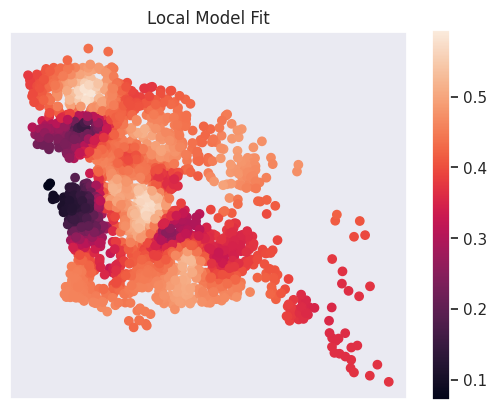

In [23]:
#Show local model fit (R squared) for all locations
prenz['R2'] = gwr_results.localR2
prenz.plot('R2', legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("Local Model Fit")
plt.show()

From the above "Local Model Fit" graph, we can see that the two light regions on the left have the highest concentration of locations with R<sup>2</sup>s over 0.5. However, in the area left of center in the neighborhood, there are many locations with R<sup>2</sup>s that are less than 0.2.

## **2.5. Demonstration of Calculating GWR Parameters Using Linear Algebra**
In this section, we are going to show how to use linear algebra to obtain parameter estimates for GWR.
First, let's review the GWR estimator for local parameter estimates for location $i$.
<br>
<br>
$$\hat{\beta}(i)=\left[ X'W(i)X \right]^{-1}X'W(i)y$$
<br>
<br>
Let's use the above formula to calculate the parameter estimates for location 1(i will be 0 since Python starts at 0). Since the weight matrix is derived through the optimization search method, we will just pull it out from the model results and use it as input for calculation.

In [24]:
#Pull the information of weight matrix of location 1 from GWR model result
W_1 = gwr_results.W[0]
W_matrix = np.diag(W_1)

Next, let's create $X$ matrix. It is the matrix with independent variables as columns. There also needs to be a column of all 1s for intercept estimation. Let's create this matrix.

In [25]:
# Create X matrix with additional column of all 1s.
b_X_1 = np.hstack([np.ones((b_X.shape[0], 1)), b_X])

Now, let's calculate the inverse matrix $\left[ X'W(i)X \right]^{-1}$ in the equation first.

In [26]:
inverse_matrix = np.linalg.inv(b_X_1.T@W_matrix@b_X_1)

Next, let's calculate the parameter estimates for location 1.

In [ ]:
beta_1 = inverse_matrix@b_X_1.T@W_matrix@b_y
beta_1

array([[ 3.30479996e+00],
       [ 1.61014298e-03],
       [ 2.06243405e-01],
       [-2.67321919e-02]])

Let's compare it with the GWR model results.

In [ ]:
gwr_results.params[0]

array([ 3.30479996e+00,  1.61014298e-03,  2.06243405e-01, -2.67321919e-02])

It turns out both results are the same. This exercise gives us a good idea of how linear algebra is applied to the calculation of a GWR model.

# **3. Conclusion**

In this lesson, we studied the theory of geographically weighted regression (GWR). We covered its definition and key concepts. Specifically, we discussed different kernel methods and distance calculation methods for GWR. We also talked about the bandwidth calculation for the model. Then, we used a real-world dataset to demonstrate how to build a GWR model. We also compared GWR model results with traditional OLS model results. Finally, we showed how we can use linear algebra to derive parameter estimates for a GWR model.

### **References**
* Oshan, Taylor M., et al. "MGWR: A Python Implementation of Multiscale Geographically Weighted Regression for Investigating Process Spatial Heterogeneity and Scale." *International Journal of Geo-Information*, vol. 8, no. 6, 2019. pp. 1-31. https://www.mdpi.com/2220-9964/8/6/269.

---
Copyright 2024 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
